In [307]:
import os
import mne
import numpy as np
import warnings
import pyedflib
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from mne.io import concatenate_raws
from autoreject import get_rejection_threshold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mne.set_log_level(verbose=False)

# Control GPU consumption
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "True"

# **Data Preparations**

## Raw Data

In [308]:
def load_data(subject_id:list, task_id:list, montage_name:str):
    dataset_path = "eeg-motor-movementimagery-dataset-1.0.0/files"

    # --- Full Path ---
    filenames = []
    for i in range(len(subject_id)):
        for j in range(len(task_id)):
            filenames.append("S"+subject_id[i]+"/S"+subject_id[i]+"R"+task_id[j]+".edf")
            
    path = [os.path.join(dataset_path, filename).replace("\\", "/") for filename in filenames]

    # --- Read EDF Files ---
    subject_raws = []
    for file_path in path:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            data = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        subject_raws.append(data)

    raw_data = concatenate_raws(subject_raws)
    
    with open("eeg-motor-movementimagery-dataset-1.0.0/files/wfdbcal", "r") as file:
        content = file.readlines()
    
    chan_name = []
    chan_order = []
    chan_mapping = {}
    order = 1
    for line in content:
        parts = line.split('\t')
        channel_name = parts[0].strip().upper()
        channel_name = channel_name.replace(".", "")
        channel_name = channel_name.replace("Z", "z")
        channel_name = channel_name.replace("FP1", "Fp1")
        channel_name = channel_name.replace("FP2", "Fp2")
        channel_name = channel_name.replace("FPz", "Fpz")
        chan_name.append(channel_name)
        order_name = "# " + str(order)
        chan_order.append(order_name)
        chan_mapping[order_name] = channel_name
        order += 1 

    channel_names = [chan_mapping[f'# {i+1}'] for i in range(64)]
    old_ch_names = raw_data.ch_names

    raw_data.rename_channels({old: new for old, new in zip(old_ch_names, channel_names)})
    # Set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_data.set_montage(montage)
    
    return raw_data

In [309]:
# --- Data Details --- 
subject_id = []
for i in range(1,2):
    subject_id.append(f'{i:003d}')
    
task_id = ["04", "08", "12"]

# --- Set Montage ---
montage_name = 'standard_1020'

# --- Set Channels Select ---
chans_selected = ['FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6',
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'Cz',
                  'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz']

# --- Set event ---
event = {'left': 2, 'right': 3}
target = ['left','right']
numclass = [2,3]

streams = load_data(subject_id, task_id, montage_name)

In [310]:
streams.get_data().shape

(64, 60000)

c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


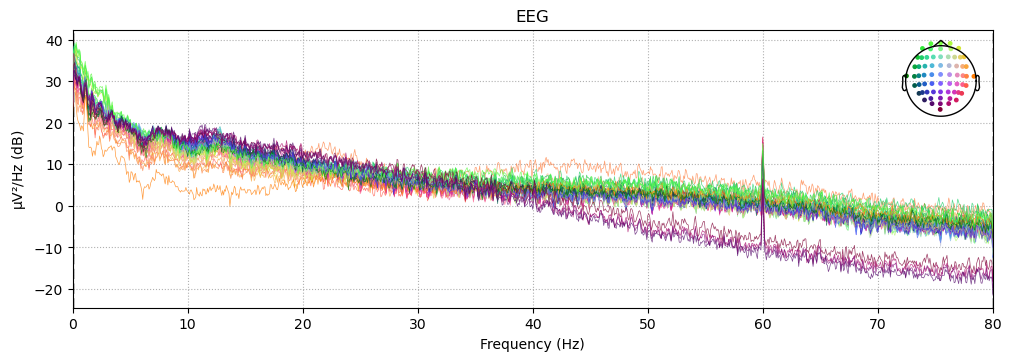

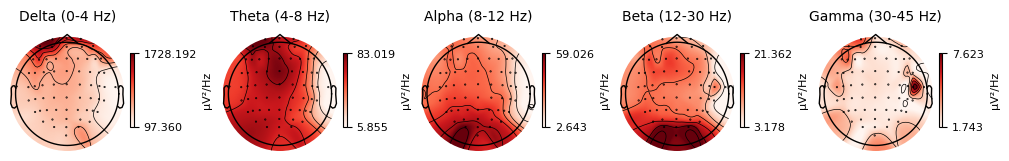

In [311]:
streams.compute_psd().plot();
streams.compute_psd().plot_topomap();

## Preprocessing

In [312]:
def preprocessing(raws_data, event, chans_selected:list):
    # --- Apply Re-reference by Common Average Reference (CAR) ---
    streams = raws_data.copy().set_eeg_reference('average', projection=True)
    
    # --- Filter Data ---
    stream_filter = streams.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
    
    # --- Apply ICA ---
    ica = mne.preprocessing.ICA(n_components=63, random_state=97, max_iter=800)
    ica.fit(stream_filter.copy())
    
    # --- Find Bad Components ---
    bad_idx, scores = ica.find_bads_eog(stream_filter.copy(), ch_name='T9', threshold=1.5)
    
    # --- Remove Bad Components ---
    ica.exclude = bad_idx
    
    # --- Apply ICA to Filtered Data ---
    stream_ica = ica.apply(stream_filter.copy(),exclude=ica.exclude)
    
    # --- Events ---
    events, event_dict = mne.events_from_annotations(stream_filter)
    
    # --- Epoch ---
    epochs = mne.Epochs(stream_ica.copy().filter(l_freq=8, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'}), events, tmin = -0.5, tmax = 4, 
                    event_id = event, preload= True, verbose=False, event_repeated='drop')
    
    # --- Selected channels are interested ---
    if chans_selected != 'all':
        epochs = epochs.pick_channels(chans_selected, ordered = False)
    
    # --- Baseline Correction ---
    Baseline = epochs.copy().filter(l_freq=8.0, h_freq=15.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})
    stream_mi = Baseline.copy().apply_baseline((-0.5, 0))
    
    # --- reject bad channels ---
    def autoreject_epochs(epochs):
        reject = get_rejection_threshold(epochs)  
        reject.update(reject)
        epochs.drop_bad(reject = reject)
        return epochs
    stream_mi = autoreject_epochs(stream_mi.copy())
    
    return stream_mi

In [313]:
epochs = preprocessing(streams, event, chans_selected)
epochs

Estimating rejection dictionary for eeg


Number of events,45
Events,left: 23right: 22
Time range,-0.500 – 4.000 s
Baseline,-0.500 – 0.000 s


c:\Users\AbsoluteZeno\anaconda3\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


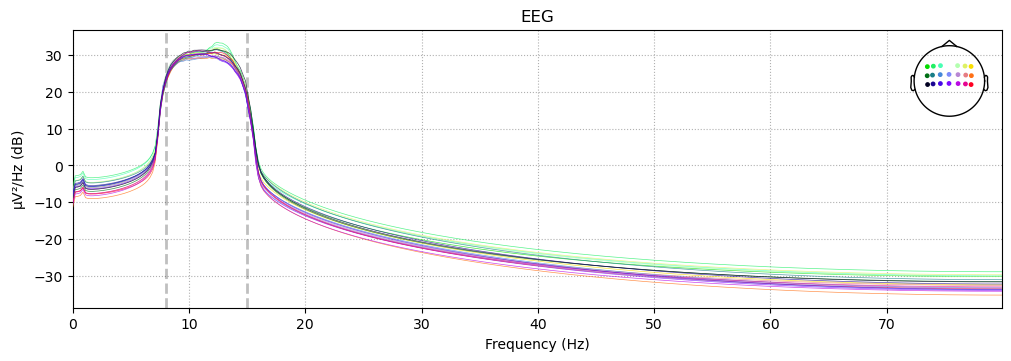

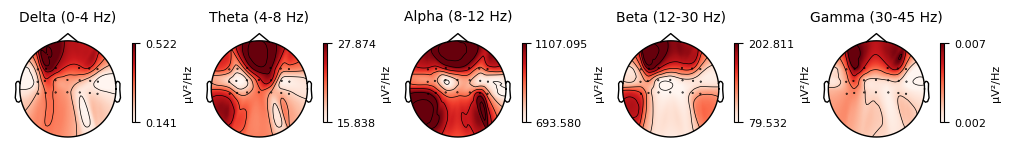

In [314]:
epochs.compute_psd().plot()
epochs.compute_psd().plot_topomap();

In [315]:
data = epochs.get_data(copy=True)

train_X = np.expand_dims(np.moveaxis(data, 0, 0), -1)
train_X.shape

(45, 20, 721, 1)

In [316]:
encoder = OneHotEncoder(sparse_output=False)

y = epochs.events[:, -1]
y = encoder.fit_transform(np.array(y).reshape(-1, 1))
y.shape

(45, 2)

In [317]:
X_train, X_test, y_train, y_test = train_test_split(train_X, y, test_size=0.35, random_state=42)
print(f'Number of train set = {X_train.shape[0]}')
print(f'Number of  test set = {X_test.shape[0]}')

Number of train set = 29
Number of  test set = 16


# **Embedded Module**

In [318]:
class Shallow_convnet(tf.keras.Model):
    tf.keras.backend.set_floatx("float64")
    def __init__(self):
        super(Shallow_convnet, self).__init__()
        self.C = len(chans_selected) # the number of electrodes
        self.fs = 160 # the sampling frequency

        # Regularizer
        self.regularizer = tf.keras.regularizers.L1L2(l1=.001, l2=.01)

        # Activation functions
        square = lambda x: x**2
        self.activation = tf.keras.layers.Activation(square)
        self.softmax = tf.keras.layers.Softmax()
        
        # Define convolutions
        conv = lambda D, kernel : tf.keras.layers.Conv2D(D, kernel, kernel_regularizer=self.regularizer)
        
        # Temporal convoltuion
        self.conv0t = conv(40, (1, int(self.fs/10)))
        
        # Spatial convolution
        self.conv0s = conv(40, (self.C, 1))
        
        # Flatteninig
        self.flatten = tf.keras.layers.Flatten()

        # Dropout
        self.dropout = tf.keras.layers.Dropout(0.5)

        # Decision making
        self.dense = tf.keras.layers.Dense(2, activation=None, kernel_regularizer=self.regularizer)

    def embedding(self, x):
        x = self.conv0t(x)
        f1 = self.activation(self.conv0s(x))

        feature = tf.concat((f1), -1)
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.dense(feature))
        return y_hat

    def GAP(self, feature):
        return tf.reduce_mean(feature, -2)

    def call(self, x):
        # Extract feature using ShallowCovNet encoder
        feature = self.embedding(x)

        # Global Average Pooling
        feature = self.GAP(feature)

        # Decision making
        y_hat = self.classifier(feature)
        return y_hat

In [319]:
def gradient(model, inputs, labels, mask=None):
    with tf.GradientTape() as tape:
        if mask is None:
            yhat = model(inputs)
        else:
            feature = model.GAP(model.embedding(inputs) * mask)
            yhat = model.classifier(feature)

        loss = tf.keras.losses.binary_crossentropy(labels, yhat)

    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

# **Agent Module**

In [320]:
class ACTOR(tf.keras.Model):
    def __init__(self, n_actions=2):
        super().__init__()
        self.actor = tf.keras.layers.Dense(n_actions, activation=None, 
                                          kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))        
    def call(self, segment):
        return self.actor(segment) # Outputs logit vector.
    
class CRITIC(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.critic = tf.keras.layers.Dense(1, activation=None,
                                           kernel_regularizer=tf.keras.regularizers.L1L2(l1=.001, l2=.01))
    def call(self, segment):
        return tf.keras.activations.sigmoid(self.critic(segment))

In [321]:
def agent_gradient(model, actor, critic, inputs, feature, labels, state, state_next):
    gamma = 0.95 # discount factor
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        loss_FM = tf.keras.losses.binary_crossentropy(labels, model(inputs))
        loss_AM = tf.keras.losses.binary_crossentropy(labels, model.classifier(feature))

        # Reward, r_t
        reward = loss_FM - loss_AM
        # Advantage, A_t
        advantage = reward[:, None] + gamma * critic(state_next) - critic(state)            
        # Critic loss
        critic_loss = 0.5 * tf.math.square(advantage)            
        # Actor loss
        actor_loss = -tf.math.log(tf.nn.softmax(actor(state))) * advantage

    critic_grad = tape1.gradient(critic_loss, critic.trainable_variables)
    actor_grad = tape2.gradient(actor_loss, actor.trainable_variables)
    return critic_loss, critic_grad, actor_loss, actor_grad, reward

# **Experiments**

In [322]:
class experiment():
    def __init__(self, train_X, train_Y, test_X, test_Y):
        # Load dataset.
        self.Xtr, self.Ytr = train_X, train_Y
        self.Xts, self.Yts = test_X, test_Y
        self.Yts = np.argmax(self.Yts, axis=-1) # To use scikit-learn accuracy function
        
        # Randomize the training dataset.
        rand_idx = np.random.permutation(self.Xtr.shape[0])
        self.Xtr, self.Ytr = self.Xtr[rand_idx, :, :, :], self.Ytr[rand_idx, :]

        # Learning schedules
        self.init_LR = 5e-4
        self.num_epochs_pre = 20 # Pre-training epochs
        self.num_epochs = 30
        self.num_batch = 20
        self.optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=self.init_LR)
        
        # Call optimizer.
        self.num_batch_iter = int(self.Xtr.shape[0]/self.num_batch)
        
    def training_FM(self):
        print(f"Classification without agent module ------\n")
        
        # Call ShallowCovNet.
        shallowcov = Shallow_convnet()
        
        # To record the loss curve.
        loss_FM = []
        for epoch in range(self.num_epochs):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(shallowcov, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_FM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Test the learned model.
        Ytr_hat = np.argmax(shallowcov(self.Xtr), axis=-1)
        Yts_hat = np.argmax(shallowcov(self.Xts), axis=-1)
        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx},\
        print(f"\nTraining accuracy: {accuracy_score(np.argmax(self.Ytr, axis=-1), Ytr_hat)}!")
        print(f"Testing accuracy: {accuracy_score(self.Yts, Yts_hat)}!\n")
        return loss_FM
    
    def training_AM(self):
        print(f"Classification with agent module ---------\n")

        # Call ShallowCovNet.
        shallowcov = Shallow_convnet()
        
        # To record the loss curve.
        loss_AM = []
        # Pre-training without the agent module
        for epoch in range(self.num_epochs_pre):
            loss_per_epoch = 0

            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]

                # Estimate loss
                loss, grads = gradient(shallowcov, xb, yb)

                # Update the parameters
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)

            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1}, Training Loss {loss_per_epoch:>.04f}")
            
        # Call agent module.
        actor = ACTOR()
        critic = CRITIC()

        reward_history = []
        actor_loss_history = []
        critic_loss_history = []
        
        # Training with the agent module
        for epoch in range(self.num_epochs - self.num_epochs_pre):
            loss_per_epoch = 0
            
            for batch in range(self.num_batch_iter):
                # Sample minibatch.
                xb = self.Xtr[batch * self.num_batch : (batch + 1) * self.num_batch, :, :, :]
                yb = self.Ytr[batch * self.num_batch : (batch + 1) * self.num_batch, :]
                # Extract full segments.
                features = shallowcov.embedding(xb)
                
                agg_wo_current = np.zeros((self.num_batch, features.shape[-1]))
                num_added = np.zeros((self.num_batch, features.shape[-1])) # To estimate the denominator.
                mask = np.zeros(features.shape) # Mask generated by the agent module
                for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
                    # print('epoch :',epoch, 'batch :', batch, 't :', t)
                    deno1 = np.copy(num_added)
                    deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                    # To avoid zero-division.
                    deno1[deno1 == 0] = 1.
                    
                    agg_w_current = agg_wo_current + features[:, 0, t, :]
                    
                    # Define state, s_t.
                    state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                    # Get action, a_t.
                    action_probs = actor(state)
                    action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 40) # (5, 112)
                    mask[:, 0, t, :] = action
                    num_added += action
                    
                    # Current feature after action decision, phi_t.
                    deno3 = np.copy(num_added)
                    deno3[deno3 == 0] = 1 # To avoid zero-division.
                    feature = (agg_wo_current + features[:, 0, t, :] * action)/deno3
                    
                    # Define next state, s_{t+1}, temporally.
                    agg_wo_current = feature
                    tmp = agg_wo_current + features[:, 0, t + 1, :]
                    state_next = np.concatenate((agg_wo_current/deno3, tmp/(deno3 + 1)), axis=-1)

                    # Calculate critic and actor loss values
                    critic_loss, critic_grads, actor_loss, actor_grads, reward = agent_gradient(shallowcov, actor, critic, xb, feature, yb, state, state_next)
                    
                    reward_history.append(reward.numpy())
                    actor_loss_history.append(actor_loss.numpy())
                    critic_loss_history.append(critic_loss.numpy())
                    
                    self.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))
                    # print("critic :",critic.trainable_variables)
                    self.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))
                                        
                # Finally, predict labels of input EEG using the selected segments.                
                # Update the parameters
                loss, grads = gradient(shallowcov, xb, yb, mask)
                self.optimizer.apply_gradients(zip(grads, shallowcov.trainable_variables))
                loss_AM.append(np.mean(loss))
                loss_per_epoch += np.mean(loss)
                
            loss_per_epoch /= self.num_batch_iter

            # Reporting
            print(f"Iteration {epoch + 1 + self.num_epochs_pre}, Training Loss {loss_per_epoch:>.04f}")

        acc = []
        for X, Y in [(self.Xtr, np.argmax(self.Ytr, axis=-1)),(self.Xts, self.Yts)]:
            features = shallowcov.embedding(X)
            agg_wo_current = np.zeros((X.shape[0], features.shape[-1]))
            num_added = np.zeros((X.shape[0], features.shape[-1])) # To estimate the denominator.
            mask = np.zeros(features.shape) # Mask generated by the agent module
            for t in tqdm(range(features.shape[-2] - 1)): # t = 1,...,T'
                # print('epoch :',epoch, 'batch :', batch, 't :', t)
                deno1 = np.copy(num_added)
                deno2 = np.copy(num_added) + 1 # For the features with the current segment.
                # To avoid zero-division.
                deno1[deno1 == 0] = 1.
                
                agg_w_current = agg_wo_current + features[:, 0, t, :]
                
                # Define state, s_t.
                state = np.concatenate((agg_wo_current/deno1, agg_w_current/deno2), axis=-1)
                # Get action, a_t.
                action_probs = actor(state)
                action = np.tile(tf.random.categorical(action_probs, 1).numpy(), 40) # (5, 112)
                mask[:, 0, t, :] = action
                num_added += action
                
                # Current feature after action decision, phi_t.
                deno3 = np.copy(num_added)
                deno3[deno3 == 0] = 1 # To avoid zero-division.
                agg_wo_current = (agg_wo_current + features[:, 0, t, :] * action)/deno3

                yhat = shallowcov.classifier(shallowcov.GAP(shallowcov.embedding(X) * mask))
                Y_hat = np.argmax(yhat, axis=-1)

                acc.append(accuracy_score(Y, Y_hat))

        # print(f"\nSubject {self.sbj_idx}, Session {self.sess_idx}, \
        print(f"\nTraining accuracy: {acc[0]}!")
        print(f"Testing accuracy: {acc[1]}!\n")
        return loss_AM, reward_history, actor_loss_history, critic_loss_history

with tf.device('/gpu:1'):
    exp = experiment(X_train, y_train, X_test, y_test)
    loss_FM = exp.training_FM()
    loss_AM, reward_history, actor_loss_history, critic_loss_history = exp.training_AM()

Classification without agent module ------

Iteration 1, Training Loss 0.6931
Iteration 2, Training Loss 0.6930
Iteration 3, Training Loss 0.6929
Iteration 4, Training Loss 0.6928
Iteration 5, Training Loss 0.6926
Iteration 6, Training Loss 0.6925
Iteration 7, Training Loss 0.6922
Iteration 8, Training Loss 0.6918
Iteration 9, Training Loss 0.6912
Iteration 10, Training Loss 0.6905
Iteration 11, Training Loss 0.6897
Iteration 12, Training Loss 0.6890
Iteration 13, Training Loss 0.6885
Iteration 14, Training Loss 0.6882
Iteration 15, Training Loss 0.6881
Iteration 16, Training Loss 0.6881
Iteration 17, Training Loss 0.6881
Iteration 18, Training Loss 0.6881
Iteration 19, Training Loss 0.6881
Iteration 20, Training Loss 0.6881
Iteration 21, Training Loss 0.6881
Iteration 22, Training Loss 0.6881
Iteration 23, Training Loss 0.6881
Iteration 24, Training Loss 0.6881
Iteration 25, Training Loss 0.6881
Iteration 26, Training Loss 0.6881
Iteration 27, Training Loss 0.6881
Iteration 28, Traini

100%|██████████| 705/705 [04:24<00:00,  2.67it/s]


Iteration 21, Training Loss 0.6893


100%|██████████| 705/705 [04:25<00:00,  2.66it/s]


Iteration 22, Training Loss 0.6901


100%|██████████| 705/705 [04:20<00:00,  2.70it/s]


Iteration 23, Training Loss 0.6904


100%|██████████| 705/705 [04:28<00:00,  2.62it/s]


Iteration 24, Training Loss 0.6911


100%|██████████| 705/705 [04:22<00:00,  2.69it/s]


Iteration 25, Training Loss 0.6933


100%|██████████| 705/705 [04:19<00:00,  2.72it/s]


Iteration 26, Training Loss 0.6927


100%|██████████| 705/705 [04:20<00:00,  2.70it/s]


Iteration 27, Training Loss 0.6927


100%|██████████| 705/705 [04:25<00:00,  2.65it/s]


Iteration 28, Training Loss 0.6912


100%|██████████| 705/705 [04:26<00:00,  2.64it/s]


Iteration 29, Training Loss 0.6909


100%|██████████| 705/705 [04:24<00:00,  2.67it/s]


Iteration 30, Training Loss 0.6917


100%|██████████| 705/705 [00:40<00:00, 17.55it/s]



Training accuracy: 0.5517241379310345!
Testing accuracy: 0.5517241379310345!



In [401]:
def training_viz(reward_history, actor_loss_history, critic_loss_history, rolling_length):
    """
    Visualized graphs of episode rewards, episode lengths, and training error during training process
    
    Args:
        rolling_length: Length of the rolling kernel used to convolve the original data
    """
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

    axs[0,0].set_title("Rewards History")
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(reward_history).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )

    batch = [b for b in range(len(reward_moving_average)) if b%705 == 0]

    for i in range(4):
        for b in batch:
            axs[i//2,i%2].axvline(x = b, color = 'gray', linestyle = '--', alpha = 0.5)
    
    axs[0,0].plot(range(len(reward_moving_average)), reward_moving_average)

    axs[0,1].set_title("Actor Training Error Node 1")
    actor_error_moving_average1 = (
        np.convolve(np.array(actor_loss_history[:,0,0]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[0,1].plot(range(len(actor_error_moving_average1)), actor_error_moving_average1)

    axs[1,0].set_title("Actor Training Error Node 2")
    actor_error_moving_average2 = (
        np.convolve(np.array(actor_loss_history[:,0,1]), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1,0].plot(range(len(actor_error_moving_average2)), actor_error_moving_average2)
    
    axs[1,1].set_title("Critic Training Error")
    critic_error_moving_average = (
        np.convolve(np.array(critic_loss_history), np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[1,1].plot(range(len(critic_error_moving_average)), critic_error_moving_average)
    plt.tight_layout()
    plt.show()

In [386]:
reward_history = np.array(reward_history)
batch_mean_reward_history = np.mean(reward_history, axis = 1)
actor_loss_history = np.array(actor_loss_history)
critic_loss_history = np.array(critic_loss_history)

batch_mean_reward_log = []
for i in range(int(reward_history.shape[0]/705)):
    batch_mean_reward_log.append(batch_mean_reward_history[i*705:(i+1)*705])

batch_mean_reward_log = np.sum(np.array(batch_mean_reward_log), axis = 1)

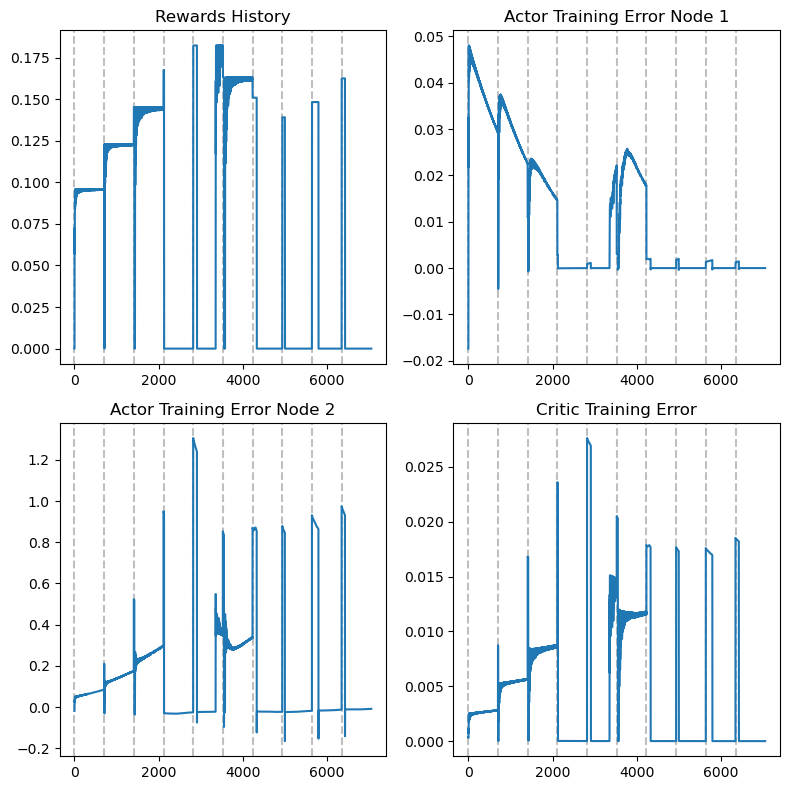

In [402]:
training_viz(reward_history[:,0],actor_loss_history,critic_loss_history[:,0,0],1)

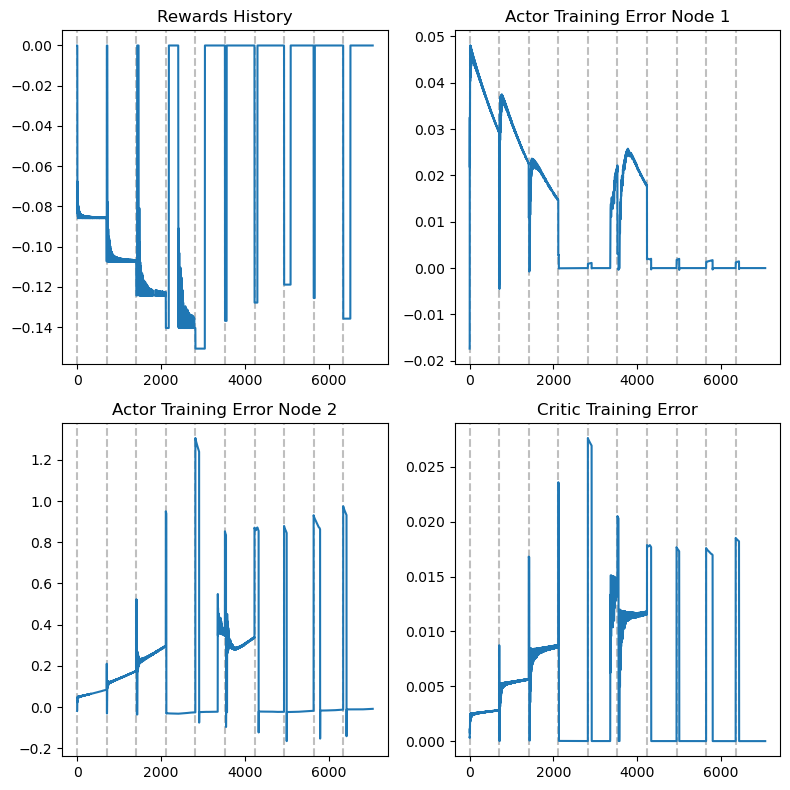

In [403]:
training_viz(reward_history[:,2],actor_loss_history,critic_loss_history[:,0,0],1)